In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/UFNO

Mounted at /content/drive
/content/drive/MyDrive/UFNO


In [ ]:
import torch
#device = torch.device("cuda:0")
#!pip install torchvision
#import torchvision
import numpy as np
from ufno import *
from lploss import *


import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
#device = torch.device('cuda:0')
model = torch.load('UFNO_predict_RMSE_lploss', map_location=torch.device('cpu'))
#model.to(device)

In [ ]:
input_test = torch.load('input_test.pt')
output_test = torch.load('output_test.pt')
input_train = torch.load('input_train.pt')
output_train = torch.load('output_train.pt')
print(input_test.shape)
print(output_test.shape)

torch.Size([92, 97, 97, 3, 3])
torch.Size([92, 97, 97, 3])


In [ ]:
# normalizing the training input data
# normalize the release time first (divide all by 6 (max value))
input_train[:,:,:,:,2] = input_train[:,:,:,:,2]/6
input_train[:,:,:,:,2]

# normalize U and V to the range [0, 1]
min_value0 = input_train[:,:,:,:,0].min().item()
max_value0 = input_train[:,:,:,:,0].max().item()

min_value1 = input_train[:,:,:,:,1].min().item()
max_value1 = input_train[:,:,:,:,1].max().item()

input_train[:,:,:,:,0] = (input_train[:,:,:,:,0] - min_value0) / (max_value0 - min_value0)
input_train[:,:,:,:,1] = (input_train[:,:,:,:,1] - min_value1) / (max_value1 - min_value1)

In [ ]:
# normalizing the input test data
# normalize the release time first (divide all by 6 (max value))
input_test[:,:,:,:,2] = input_test[:,:,:,:,2]/6

# normalize U and V to the range [0, 1]
min_value0 = input_test[:,:,:,:,0].min().item()
max_value0 = input_test[:,:,:,:,0].max().item()

min_value1 = input_test[:,:,:,:,1].min().item()
max_value1 = input_test[:,:,:,:,1].max().item()

input_test[:,:,:,:,0] = (input_test[:,:,:,:,0] - min_value0) / (max_value0 - min_value0)
input_test[:,:,:,:,1] = (input_test[:,:,:,:,1] - min_value1) / (max_value1 - min_value1)

In [ ]:
mean_value = 1.990989489137778e-17
std_value = 2.3570086714735916e-16

In [ ]:
y_train_pred = model(input_train[:,:,:,:,:]).view(-1,97,97,3)

In [ ]:
# training loss in original scale
output_train_pred = y_train_pred * std_value + mean_value

myloss = LpLoss(size_average=True, reduction=True)

loss = myloss(output_train_pred[:,:,:,:].reshape(-1), output_train[:,:,:,:].reshape(-1))
loss

In [ ]:
import time
start_time = time.time()

#model prediction on test data
y_pred = model(input_test[:,:,:,:,:]).view(-1,97,97,3)

end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time: {inference_time} seconds")

torch.save(y_pred, 'y_pred.pt')

#y_pred = torch.load('/content/drive/MyDrive/UFNO/y_pred.pt')

Inference time: 113.19622015953064 seconds


In [ ]:
# transform to original scale
output_test_pred = y_pred * std_value + mean_value

# Replace negative values in output_test_pred[92,:,:,3] with zero
output_test_pred = torch.where(output_test_pred < 0, torch.tensor(0), output_test_pred)

In [ ]:
# Test data RMSE loss in original scale

from lploss import *
myloss = LpLoss(size_average=True, reduction=True)

loss = myloss(output_test_pred[:,:,:,:].reshape(-1), output_test[:,:,:,:].reshape(-1))
loss

tensor(7.4395e-18, grad_fn=<MeanBackward0>)

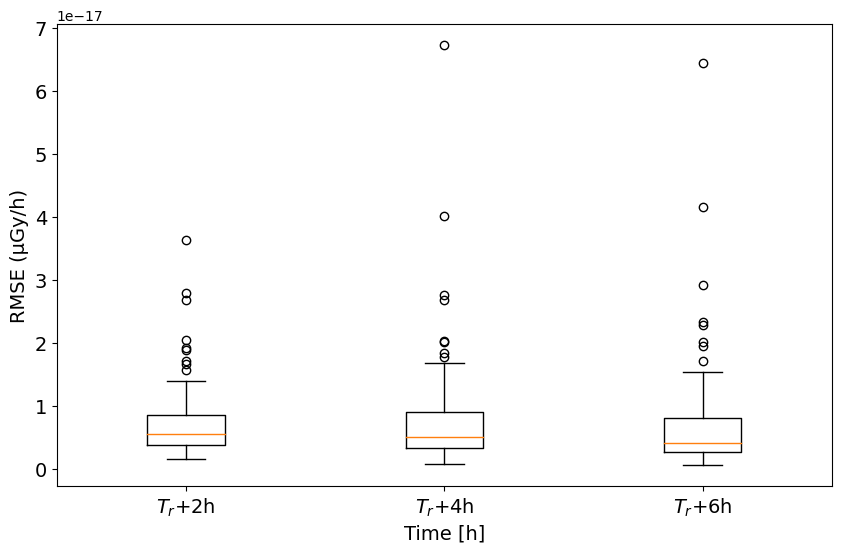

In [ ]:
# RMSE vs time analysis

loss0_list = []
loss1_list = []
loss2_list = []
#output_test_pred_out_of_plume= np.zeros(92)

for i in range(92):
  loss0 = myloss(output_test_pred[i,:,:,0].reshape(-1), output_test[i,:,:,0].reshape(-1)).item()
  loss1 = myloss(output_test_pred[i,:,:,1].reshape(-1), output_test[i,:,:,1].reshape(-1)).item()
  loss2 = myloss(output_test_pred[i,:,:,2].reshape(-1), output_test[i,:,:,2].reshape(-1)).item()

  loss0_list.append(loss0)
  loss1_list.append(loss1)
  loss2_list.append(loss2)


# Convert the list of arrays to a single NumPy array using np.concatenate
#percentiles = np.concatenate(percentiles_list, axis=0)

# Combine the lists into a single list of lists for boxplot
data = [loss0_list, loss1_list, loss2_list]

plt.figure(figsize=(10, 6))
# Create boxplots for each list at different time steps
plt.boxplot(data)
plt.xlabel('Time [h]', fontsize=14)
plt.ylabel('RMSE (μGy/h)', fontsize=14)
plt.xticks(ticks=[1, 2, 3], labels=['$T_{r}$+2h', '$T_{r}$+4h', '$T_{r}$+6h'], fontsize=14)  # Adjust x-axis labels
plt.yticks(fontsize=14)
#plt.grid(True)
plt.show()

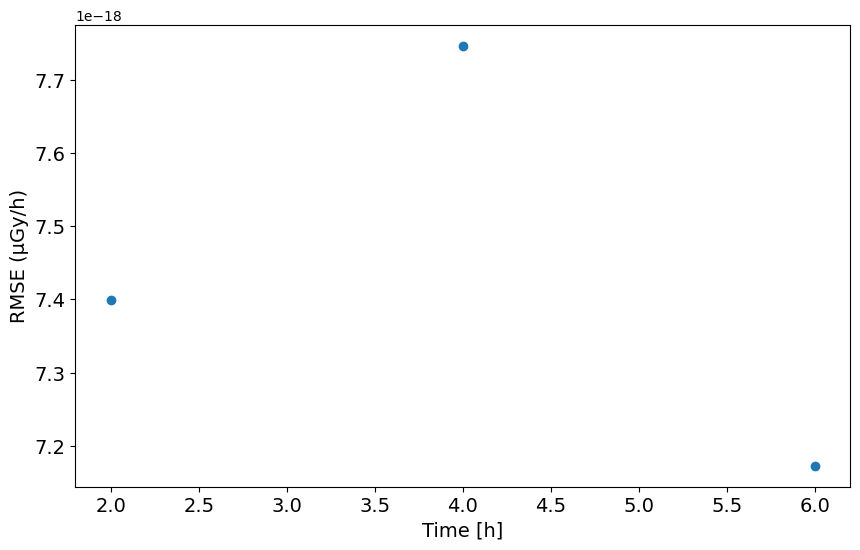

In [ ]:
loss0 = myloss(output_test_pred[:,:,:,0].reshape(-1), output_test[:,:,:,0].reshape(-1))
loss1 = myloss(output_test_pred[:,:,:,1].reshape(-1), output_test[:,:,:,1].reshape(-1))
loss2 = myloss(output_test_pred[:,:,:,2].reshape(-1), output_test[:,:,:,2].reshape(-1))

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot([2, 4, 6], [loss0.detach().numpy(), loss1.detach().numpy(), loss2.detach().numpy()], marker='o', linestyle='None')
# Set the y-axis label format to display values in e-15
#plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1e}'))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(False)

plt.xlabel('Time [h]', fontsize=14)
plt.ylabel('RMSE (μGy/h)', fontsize=14)

plt.show()

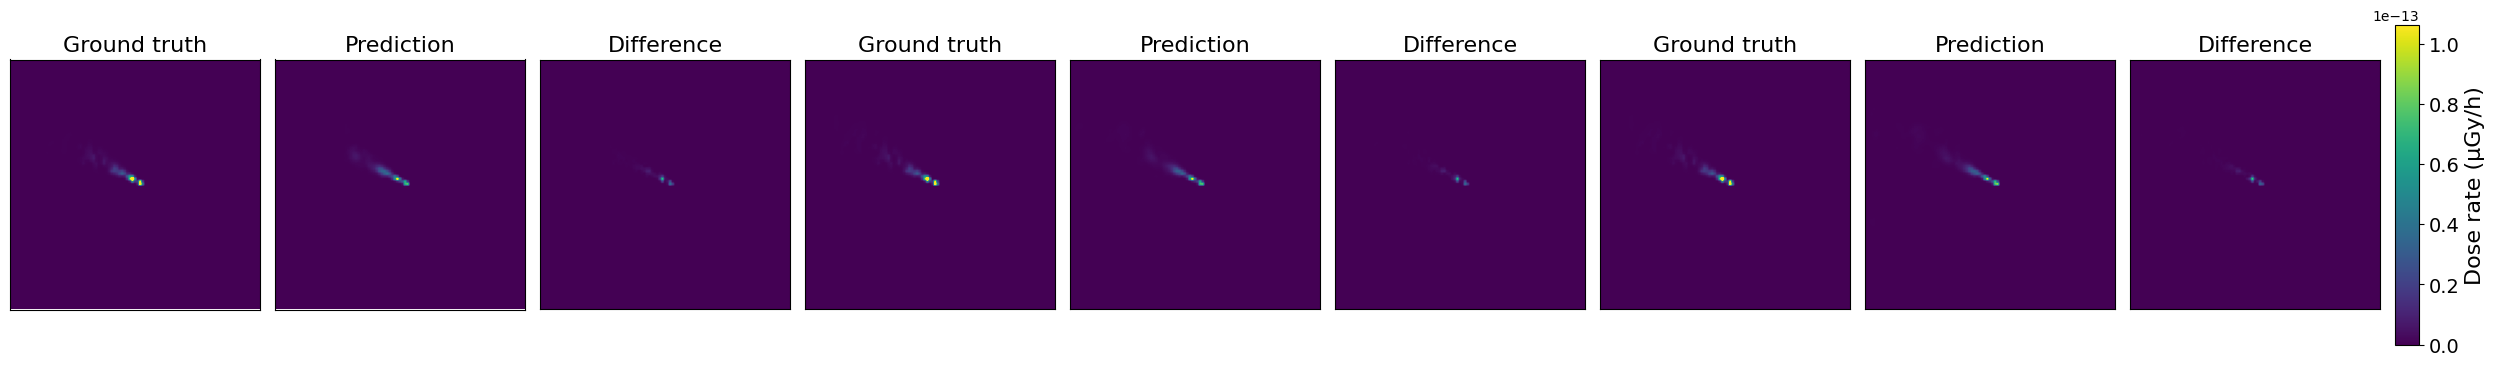

tensor(0.)
tensor(1.0643e-13)


In [ ]:
# Select a specific sample you want to visualize
sample_index = 34 #49 67 is good  # Replace with the sample index you want to visualize
time_indices = [0, 1, 2]

# calculate the absolute error tensor
error_tensor = torch.abs(output_test[:,:,:,:] - output_test_pred[:,:,:,:])

# Create a common colorbar legend for all map

vmin = float('inf')
vmax = float('-inf')

for t in time_indices:
    true_min = output_test[sample_index, :, :, t].min()
    true_max = output_test[sample_index, :, :, t].max()
    pred_min = output_test_pred[sample_index, :, :, t].min()
    pred_max = output_test_pred[sample_index, :, :, t].max()
    err_min = error_tensor[sample_index, :, :, t].min()
    err_max = error_tensor[sample_index, :, :, t].max()

    vmin = min(vmin, true_min, pred_min, err_min)
    vmax = max(vmax, true_max, pred_max, err_max)
    #vmax = 1.1e-13

# Create subplots for each time step
plt.figure(figsize=(24, 4))

for i, t in enumerate(time_indices):
    true_map = output_test[sample_index, :, :, t].detach().numpy()
    predicted_map = output_test_pred[sample_index, :, :, t].detach().numpy()
    error_map = error_tensor[sample_index, :, :, t].detach().numpy()

    plt.subplot(1, 9, i * 3 + 1)
    plt.imshow(true_map, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title('Ground truth', fontsize=16)
    plt.gca().set_xticks([])  # Remove x-axis ticks
    plt.gca().set_yticks([])  # Remove y-axis ticks

    plt.subplot(1, 9, i * 3 + 2)
    plt.imshow(predicted_map, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title('Prediction', fontsize=16)
    plt.gca().set_xticks([])  # Remove x-axis ticks
    plt.gca().set_yticks([])  # Remove y-axis ticks

    plt.subplot(1, 9, i * 3 + 3)
    img = plt.imshow(error_map, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title('Difference', fontsize=16)
    plt.gca().set_xticks([])  # Remove x-axis ticks
    plt.gca().set_yticks([])  # Remove y-axis ticks

plt.tight_layout()

# Create a colorbar for the error map (third column)
cax = plt.axes([1, 0.1, 0.01, 0.8])  # Define position and size of the colorbar
cbar = plt.colorbar(img, cax=cax)

cbar.ax.tick_params(labelsize=14)
cbar.set_label('Dose rate (μGy/h)', fontsize=16)

plt.show()

print(vmin)
print(vmax)


In [ ]:
# RMSE loss in original scale

myloss = LpLoss(size_average=True, reduction=True)

loss = myloss(output_test_pred[83,:,:,2].reshape(-1), output_test[83,:,:,2].reshape(-1))
loss

tensor(1.3160e-17, grad_fn=<MeanBackward0>)

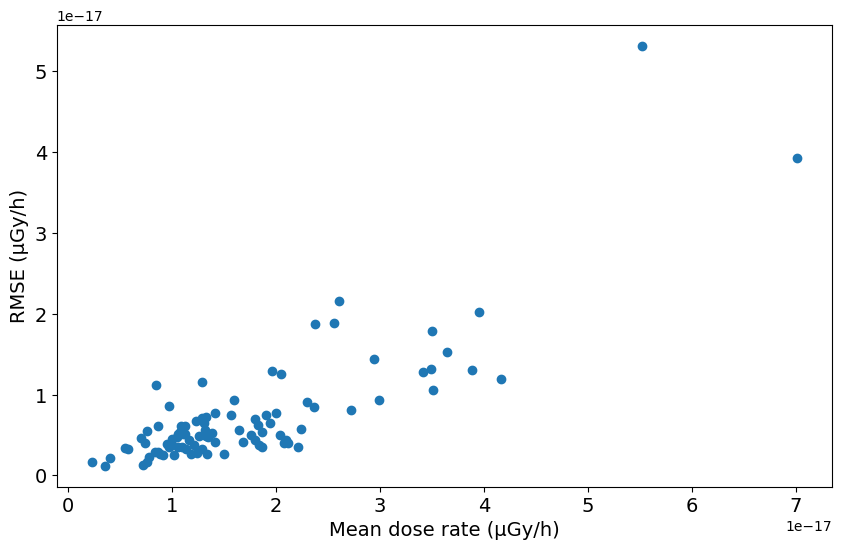

Correlation coefficient between RMSE and Mean Dose: 0.8180155726037274


In [ ]:
# RMSE vs mean dose across the whole map
MeanDose = np.zeros(92)
loss = np.zeros(92)
normalized_loss = np.zeros(92)

for i in range(92):
  MeanDose[i] = output_test[i,:,:,:].mean()
  loss[i] = myloss(output_test_pred[i,:,:,:].reshape(-1), output_test[i,:,:,:].reshape(-1))
  #normalized_loss[i] = loss[i]/MeanDose[i]

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(MeanDose, loss, marker='o', linestyle='None')
# Set the y-axis label format to display values in e-15
#plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1e}'))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(False)

plt.xlabel('Mean dose rate (μGy/h)', fontsize=14)
plt.ylabel('RMSE (μGy/h)', fontsize=14)

plt.show()

# Calculate the correlation coefficient
correlation = np.corrcoef(MeanDose, loss)[0, 1]
print(f"Correlation coefficient between RMSE and Mean Dose: {correlation}")



In [ ]:
#R2 score on training data
output_train_flat = output_train.reshape(-1)
output_train_pred_flat = output_train_pred.reshape(-1)

mean_true = output_train_flat.mean()

# Calculate total sum of squares
ss_total = ((output_train_flat - mean_true)** 2).sum()

# Calculate residual sum of squares
ss_residual = ((output_train_flat - output_train_pred_flat) ** 2) .sum()

# Calculate R2 score
r2 = 1 - (ss_residual / ss_total)

print("R2 Score on training data:", r2)


R2 Score on training data: tensor(0.9610, grad_fn=<RsubBackward1>)


In [ ]:
#R2 score on testing data
output_test_flat = output_test.reshape(-1)
output_test_pred_flat = output_test_pred1.reshape(-1)

mean_true = output_test_flat.mean()

# Calculate total sum of squares
ss_total = ((output_test_flat - mean_true)** 2).sum()

# Calculate residual sum of squares
ss_residual = ((output_test_flat - output_test_pred_flat) ** 2) .sum()

# Calculate R2 score
r2 = 1 - (ss_residual / ss_total)

print("R2 Score:", r2)


R2 Score: tensor(0.7857, grad_fn=<RsubBackward1>)


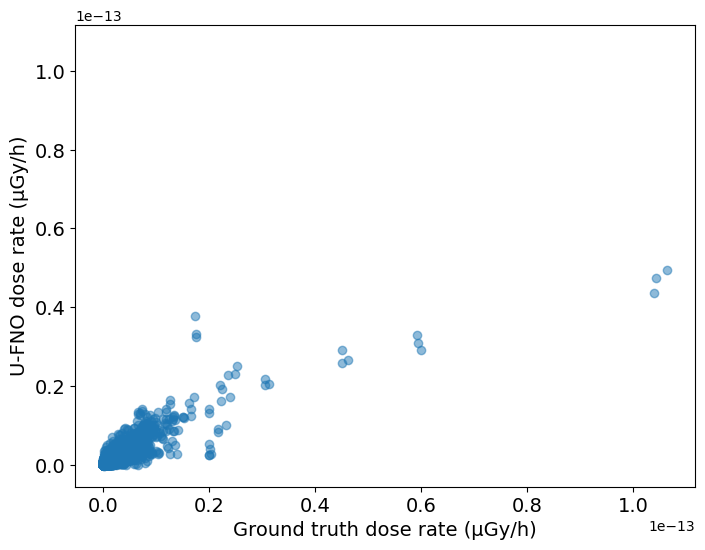

In [ ]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(output_test[:,:,:,:].detach().numpy(), output_test_pred[:,:,:,:].detach().numpy(), alpha=0.5)

# Add the bisector line (y = x)
plt.plot([output_test.min(), output_test.max()], [output_test.min(), output_test.max()], color='none', label='45° Bisector')

plt.xlabel('Ground truth dose rate (μGy/h)', fontsize=14)
plt.ylabel('U-FNO dose rate (μGy/h)', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.show()

RMSE: tensor(2.9716e-15, grad_fn=<MeanBackward0>)
R2 Score: tensor(0.5760, grad_fn=<RsubBackward1>)


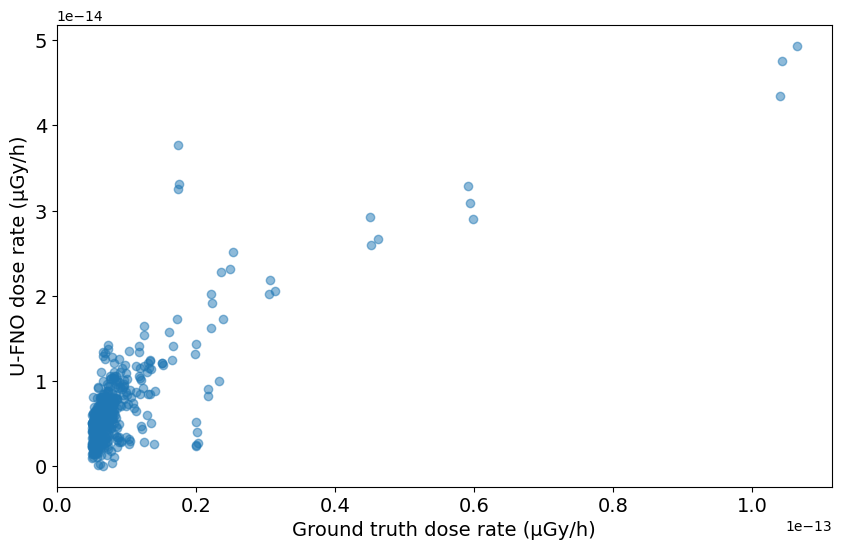

In [ ]:
# high dose areas
non_zero_mask = (output_test > 5e-15)

# Adding a small constant to avoid log of zero due to floating point representation
output_test_pred_plume = output_test_pred[non_zero_mask]#+1e-40
output_test_plume = output_test[non_zero_mask]

# RMSE loss in plume region
from lploss import *

loss = myloss(output_test_pred_plume, output_test_plume)
print("RMSE:", loss)

#R2 score in plume region
output_test_flat = output_test_plume
output_test_pred_flat = output_test_pred_plume

mean_true = output_test_flat.mean()

# Calculate total sum of squares
ss_total = ((output_test_flat - mean_true)** 2).sum()

# Calculate residual sum of squares
ss_residual = ((output_test_flat - output_test_pred_flat) ** 2).sum()

# Calculate R2 score
r2 = 1 - (ss_residual / ss_total)

print("R2 Score:", r2)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(output_test_plume.detach().numpy(), output_test_pred_plume.detach().numpy(), alpha=0.5)

#plt.ylim(0, 1e-13)

plt.xlabel('Ground truth dose rate (μGy/h)', fontsize=14)
plt.ylabel('U-FNO dose rate (μGy/h)', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.show()

<ipython-input-28-db141534c83e>:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(x=output_test_plume.detach().numpy(), y=output_test_pred_plume.detach().numpy(), cmap='viridis', alpha=0.85, shade=True, thresh=0.05)


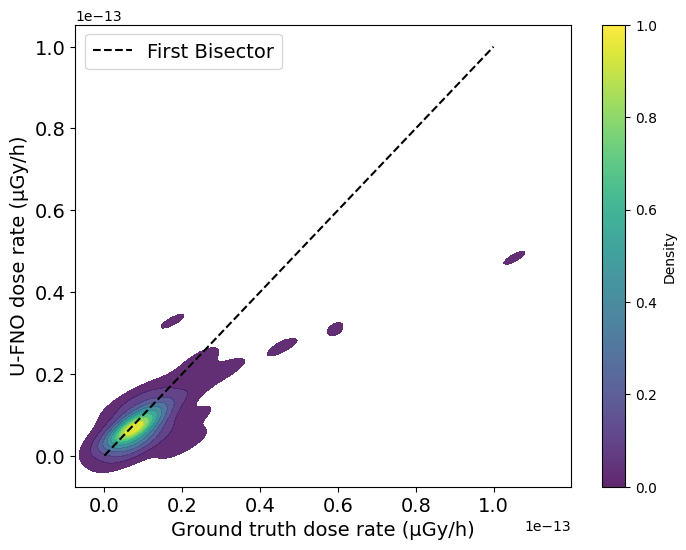

In [ ]:
# Inside the plume (we use only high dose areas due to the high number of data points (dose rates > 5e-15))
# Contour plot to visualzie the scatter plot between predictions and true values
non_zero_mask = (output_test > 6e-15)

# Adding a small constant to avoid log of zero due to floating point representation
output_test_pred_plume = output_test_pred[non_zero_mask]#+1e-40
output_test_plume = output_test[non_zero_mask]

# Create a 2D kernel density estimation (KDE) plot with contours
plt.figure(figsize=(8, 6))
ax = sns.kdeplot(x=output_test_plume.detach().numpy(), y=output_test_pred_plume.detach().numpy(), cmap='viridis', alpha=0.85, shade=True, thresh=0.05)

# Adding a colorbar
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Density')

# Plotting the first bisector line
plt.plot([0, 1e-13], [0, 1e-13], color='black', linestyle='--', label='First Bisector')

# Adding labels, title, and legend
plt.xlabel('Ground truth dose rate (μGy/h)', fontsize=14)
plt.ylabel('U-FNO dose rate (μGy/h)', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.legend(prop={'size': 14})  # Set label font size here

# Show the plot

plt.show()


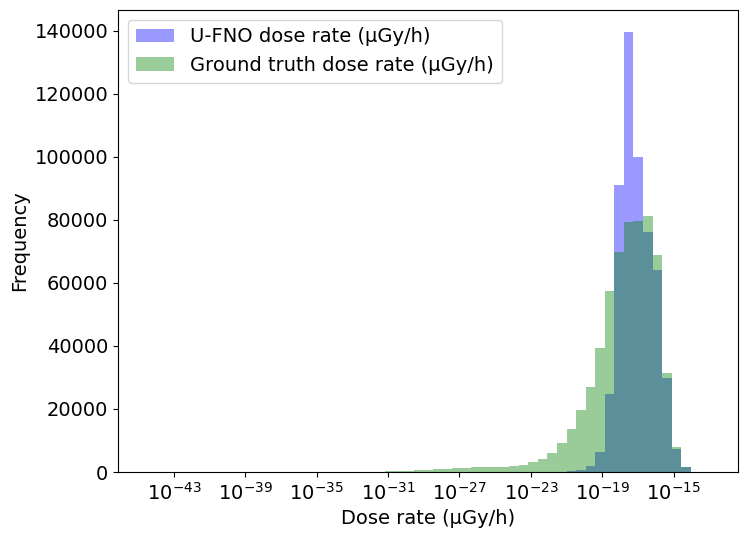

In [ ]:
# Histogram of dose values in the plume region
# Plotting histograms

non_zero_mask = (output_test > 0)

# Adding a small constant to avoid log of zero due to floating point representation
output_test_pred_plume = output_test_pred[non_zero_mask]+1e-32
output_test_plume = output_test[non_zero_mask]

plt.figure(figsize=(8, 6))

# Use logspace to create logarithmically spaced bins
bins = np.logspace(min(np.log10(min(output_test_pred_plume.detach().numpy().min(), output_test_plume.detach().numpy().min())), np.log10(min(output_test_pred_plume.detach().numpy().min(), output_test_plume.detach().numpy().min()))),
                   max(np.log10(max(output_test_pred_plume.detach().numpy().max(), output_test_plume.detach().numpy().max())), np.log10(max(output_test_pred_plume.detach().numpy().max(), output_test_plume.detach().numpy().max()))),
                   60)

# Plot histogram for tensor1 with blue color
plt.hist(output_test_pred_plume.detach().numpy()-1e-32, bins=bins, alpha=0.4, color='blue', label='U-FNO dose rate (μGy/h)')

# Plot histogram for tensor2 with orange color
plt.hist(output_test_plume.detach().numpy(), bins=bins, alpha=0.4, color='green', label='Ground truth dose rate (μGy/h)')

# Setting x-axis to logarithmic scale
plt.xscale('log')

# Adding labels and title
plt.xlabel('Dose rate (μGy/h)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(prop={'size': 14})  # Set label font size here
#plt.grid(True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()


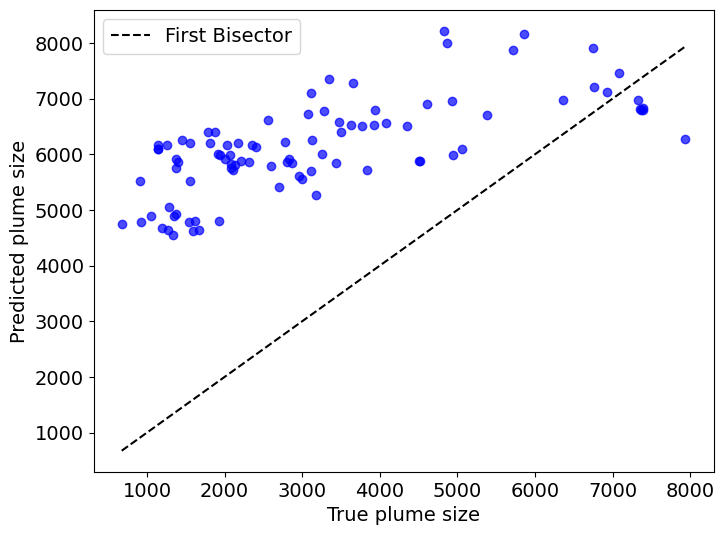

In [ ]:
# for each test sample, define the plume extent as the # of grids with dose rate > 0
# calculate the ratio of plume extent overestimation by UFNO
#percentile = torch.quantile(output_test[:,:,:,2], 0.25, dim=0)

output_test_plume = np.zeros(92)
output_test_pred_plume = np.zeros(92)


#output_test_pred[i,:,:,2].mean())

for i in range(92):
  plume_mask_true = (output_test[i,:,:,2] > 0)#*output_test[i,:,:,2].max())#torch.quantile(output_test[:,:,:,2], 0.75, dim=0)) # extract the data within the true plume only
  plume_mask_pred = (output_test_pred[i,:,:,2] > 0)#*output_test_pred[i,:,:,2].max())# torch.quantile(output_test_pred[:,:,:,2], 0.75, dim=0)) # extract the data within the pred plume only
  output_test_plume[i] = output_test[i,:,:,2][plume_mask_true].numel()
  output_test_pred_plume[i] = output_test_pred[i,:,:,2][plume_mask_pred].numel()


ratio = output_test_pred_plume / output_test_plume


plt.figure(figsize=(8, 6))
plt.scatter(output_test_plume, output_test_pred_plume, color='blue', alpha=0.7)
plt.xlabel('True plume size', fontsize=14)
plt.ylabel('Predicted plume size', fontsize=14)
plt.plot([output_test_plume.min(), output_test_plume.max()], [output_test_plume.min(), output_test_plume.max()], color='black', linestyle='--', label='First Bisector')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.legend(prop={'size': 14})#, loc='lower right')  # Set label font size here

# Plotting the first bisector line
plt.show()

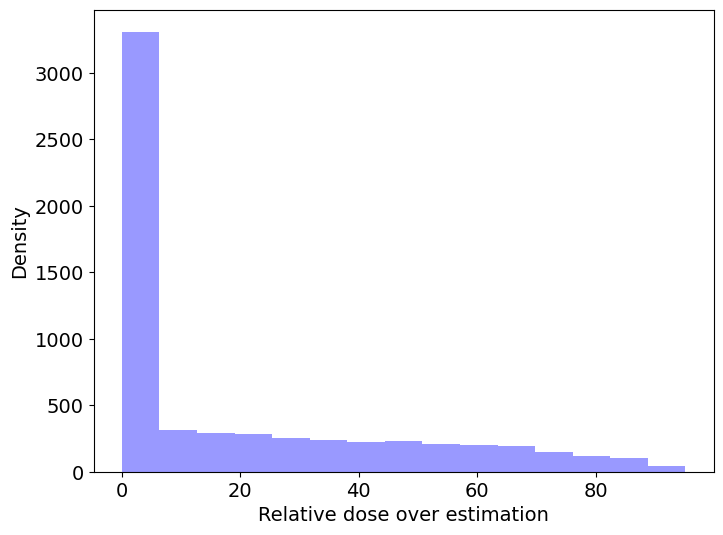

In [ ]:
# Outside the plume (we use only low dose areas due to the high number of data points (dose rates > 5e-15))
# Study how much do the false positives represent in (percentiles) relative to the plume, they should be small to be good

percentiles_list = []
#output_test_pred_out_of_plume= np.zeros(92)

for i in range(92):
  zero_mask = (output_test[i,:,:,2] == 0)
  output_test_pred_out_of_plume = output_test_pred[i,:,:,2][zero_mask].detach().numpy()

  #keep the non zero (false positives)
  output_test_pred_out_of_plume = output_test_pred_out_of_plume[np.nonzero(output_test_pred_out_of_plume)]

  # Flatten the tensor along the x and y dimensions (.view(-1)) to get the predicted plume's percentiles
  pred_plume_values = output_test_pred[i,:,:,2][(output_test_pred[i,:,:,2] > 0)].view(-1).detach().numpy()

  # Sort the flattened tensor to find percentiles using np.searchsorted
  pred_plume_values = np.sort(pred_plume_values)

  # Calculate the percentiles for each element in 'a' using interpolation
  percentile = (np.searchsorted(pred_plume_values, output_test_pred_out_of_plume, side='right') / len(pred_plume_values)) * 100

  percentiles_list.append(percentile)

# Convert the list of arrays to a single NumPy array using np.concatenate
percentiles = np.concatenate(percentiles_list, axis=0)

plt.figure(figsize=(8, 6))

plt.hist(percentiles_a, bins=15, alpha=0.4, color='blue')


plt.xlabel('Relative dose over estimation', fontsize=14)
plt.ylabel('Density', fontsize=14)
#plt.legend(prop={'size': 14})  # Set label font size here
#plt.grid(True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()


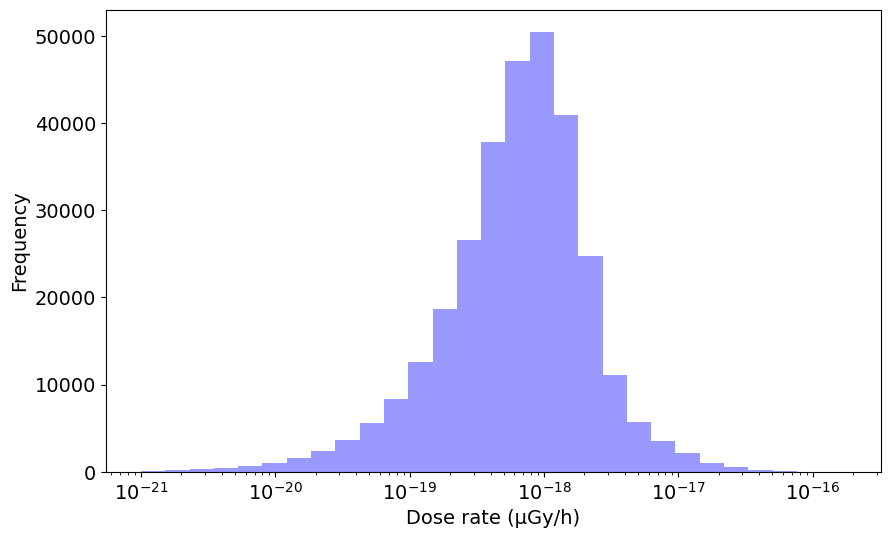

In [ ]:
# study the difference in plume extent after 6 hours (steady state)

#non_zero_mask = (output_test < 1e-30)
zero_mask = (output_test[:,:,:,2] == 0)

#output_test_pred[:,:,:,2].detach().numpy()

# Adding a small constant to avoid log of zero due to floating point representation
output_test_pred_plume = output_test_pred[:,:,:,2][zero_mask]+1e-21

# Use logspace to create logarithmically spaced bins
log_bins = np.logspace(np.log10(output_test_pred_plume.detach().numpy().min()), np.log10(output_test_pred_plume.detach().numpy().max()), 30)

plt.figure(figsize=(10, 6))

# Plot histogram for dose rates in grids that were supposed to have zero values
plt.hist((output_test_pred_plume.detach().numpy()-1e-21), bins=log_bins, alpha=0.4, color='blue')

# Setting x-axis to logarithmic scale
plt.xscale('log')

# Adding labels and title
plt.xlabel('Dose rate (μGy/h)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
#plt.legend(prop={'size': 14})  # Set label font size here
#plt.grid(True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()

<Figure size 800x600 with 0 Axes>

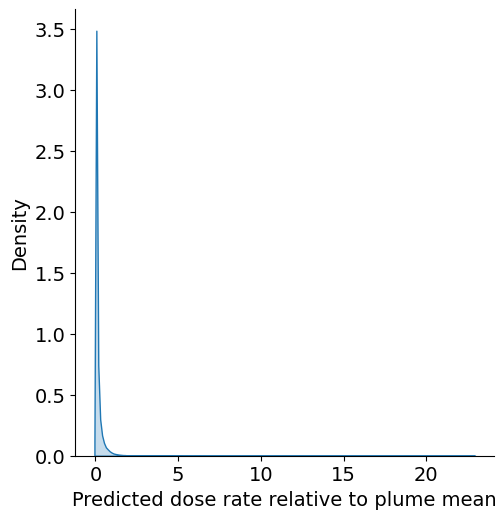

In [ ]:
# Outside the plume (we use only low dose areas due to the high number of data points (dose rates > 5e-15))

normalized_output_test_pred_out_of_plume_list = []
MeanDose_pred_plume = np.zeros(92)

for i in range(92):
  zero_mask = (output_test[i,:,:,2] == 0)
  output_test_pred_out_of_plume = output_test_pred[i,:,:,2][zero_mask].detach().numpy()
  # find the mean dose in the plume
  MeanDose_pred_plume[i] = output_test_pred[i,:,:,2][(output_test_pred[i,:,:,2] > 0)].mean().item()
  output_test_pred_out_of_plume = output_test_pred_out_of_plume/MeanDose_pred_plume[i]
  normalized_output_test_pred_out_of_plume_list.append(output_test_pred_out_of_plume)

# Convert the list of arrays to a single NumPy array using np.concatenate
normalized_pred_out_plume = np.concatenate(normalized_output_test_pred_out_of_plume_list, axis=0)

plt.figure(figsize=(8, 6))


sns.displot(normalized_pred_out_plume, kind='kde', fill=True)
#plt.hist(normalized_pred_out_plume, bins=40, alpha=0.4, color='blue')

plt.xlabel('Predicted dose rate relative to plume mean', fontsize=14)
plt.ylabel('Density', fontsize=14)
#plt.legend(prop={'size': 14})  # Set label font size here
#plt.grid(True)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()
